In [1]:
import pandas as pd

# Load the dataa
data = data = pd.read_csv("C:/Users/admin/OneDrive/maytinh/Downloads/New folder/META_stock_data.csv") 


In [2]:
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-09-30,48.796001,47.222000,48.599998,48.174000,29399000.0,48.174000
1,2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2,2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
3,2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
4,2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999


In [3]:
data['MA21'] = data['Close'].rolling(window=21).mean()

In [4]:
def calculate_rsi(data, window=21):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

data['RSI'] = calculate_rsi(data['Close'])


In [5]:
data = data.dropna()  # Loại bỏ các hàng chứa giá trị NaN do tính RSI và MA

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619 entries, 20 to 638
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       619 non-null    object 
 1   High       619 non-null    float64
 2   Low        619 non-null    float64
 3   Open       619 non-null    float64
 4   Close      619 non-null    float64
 5   Volume     619 non-null    float64
 6   Adj Close  619 non-null    float64
 7   MA21       619 non-null    float64
 8   RSI        619 non-null    float64
dtypes: float64(8), object(1)
memory usage: 48.4+ KB


In [7]:
import numpy as np

# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(how='any', axis=0, inplace=True)

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
import warnings

pd.options.mode.chained_assignment = None 
# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close', 'Open', 'High', 'Low']
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (495, 4)
Validation data shape: (61, 4)
Test data shape: (63, 4)


In [18]:
# Training data
seq_len = 21
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i])
  y_train.append(train_data[:, 0][i]) 
X_train, y_train = np.array(X_train), np.array(y_train)

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (490, 21, 4) (490,)
Validation set shape (42, 21, 4) (42,)
Testing set shape (44, 21, 4) (44,)


In [19]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
from keras.models import Model

input_layer = Input(shape=(21, 4))
x = LSTM(100, return_sequences=False)(input_layer)  # return_sequences=False
output_layer = Dense(1)(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
import time

start_time = time.time()
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_val, y_val), verbose=1)
# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 3))), axis=1))[:,0]
end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.4555 - val_loss: 0.0698
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0422 - val_loss: 0.0394
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0142 - val_loss: 0.0854
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0081 - val_loss: 0.0705
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0076 - val_loss: 0.0727
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0064 - val_loss: 0.0603
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0060 - val_loss: 0.0669
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - val_loss: 0.0748
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0059 - val_loss: 0.0588
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0056 - val_loss: 0.0635
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - val_loss: 0.0679
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

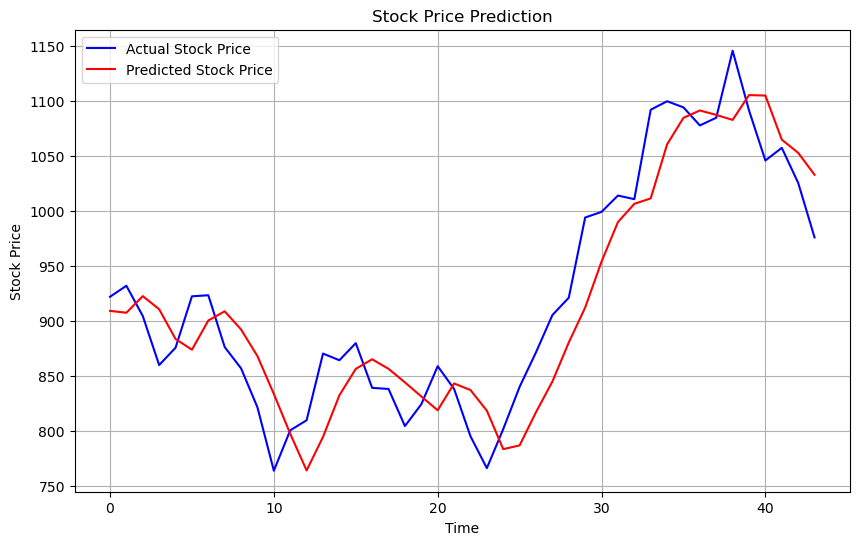

Root Mean Squared Error: 41.211682717910115
Mean Absolute Percentage Error: 0.03840342218857388
Thời gian training mô hình 21.811793565750122


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")

print('Thời gian training mô hình',training_time)